## 1. PE samples of new candidate events and importing catalog of candidate properties

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import pickle

In [2]:
# We use cogwheel for plotting (https://github.com/jroulet/cogwheel)
import sys
sys.path.append('/data/jayw/IAS/GW/cogwheel') # Download cogwheel and change path here
from cogwheel import sampling, posterior, data, likelihood, gw_plotting, utils
from cogwheel.cosmology import z_of_d_luminosity

In [3]:
# Please download the PE samples from https://drive.google.com/drive/folders/1YkuIo-yIJhIOSX3B0zRGlSJzwIT5D61U?usp=sharing
# and rename the path below
samples_dir = Path('/data/jayw/IAS/GW/Data/HM_O3a_search/PE_samples')

In [4]:
# List of new events from arXiv:2312.06631 Table 1

New_IAS_events = [(0, 'GWC190605_025957'),
                 (1, 'GWC190806_033721'),
                 (2, 'GWC190524_134109'),
                 (3, 'GWC191113_103541'),
                 (4, 'GWC190615_030234'),
                 (5, 'GWC190604_103812'),
                 (6, 'GWC191228_195619'),
                 (7, 'GWC200304_172806'),
                 (8, 'GWC190530_030659'),
                 (9, 'GWC190511_163209'),
                 (10, 'GWC200210_100022'),
                 (11, 'GWC200301_211019'),
                 (12, 'GWC190911_195101'),
                 (13, 'GWC190530_133833')]

In [5]:
eventname = New_IAS_events[6][1]

In [6]:
def transform_samples(s, lnl_cutoff=25):
    s['chieff'] = (s['m1']*s['s1z']+s['m2']*s['s2z'])/(s['m1']+s['m2'])
    s['lnq'] = -np.abs(s['lnq'] )
    s['z'] = z_of_d_luminosity(s['d_luminosity'])
    s['m1_source'] = s['m1']/(1+ s['z'])
    s['m2_source'] = s['m2']/(1+ s['z'])
    s['mtot'] = (s['m1']+s['m2'])
    s['q'] = np.exp(s['lnq'])
    s['s1_perp'] = np.sqrt(s['s1x_n']**2 + s['s1y_n']**2)
    s = s[s.lnl > (s.lnl.max() - lnl_cutoff)]
    s = s[s.lnl > 2]
    return(s)

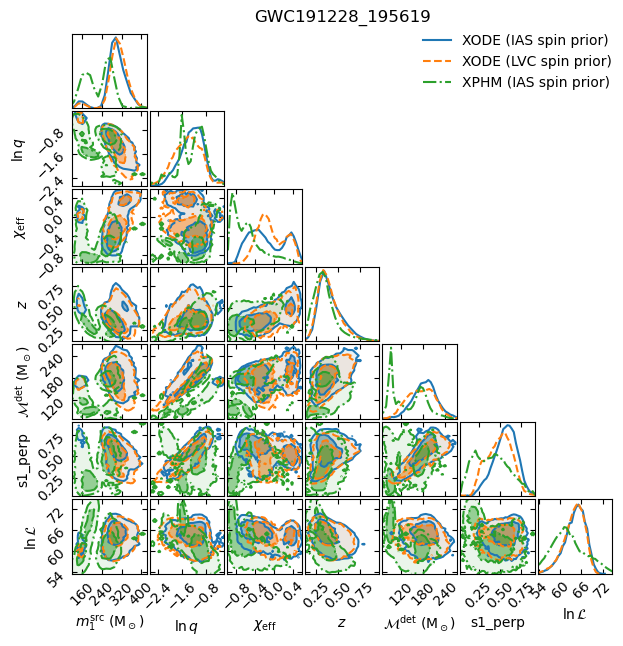

In [7]:
s0 = transform_samples(pd.read_feather(samples_dir/f'{eventname}/IntrinsicIASPrior_IMRPhenomXODE_P_HM/samples.feather'))
s1 = transform_samples(pd.read_feather(samples_dir/f'{eventname}/IntrinsicLVCPrior_IMRPhenomXODE_P_HM/samples.feather'))
s2 = transform_samples(pd.read_feather(samples_dir/f'{eventname}/IntrinsicIASPrior_IMRPhenomXPHM_P_HM/samples.feather'))

# Note that the samples using NAUTILUS come with weights and these are implicitly being
# passed to the plotter
mcp = gw_plotting.MultiCornerPlot((s0, s1, s2),
                    bins=40, labels=['XODE (IAS spin prior)', 'XODE (LVC spin prior)', 'XPHM (IAS spin prior)'],
                       params=['m1_source', 'lnq', 'chieff', 'z','mchirp','s1_perp', 'lnl'], density=True)

mcp.plot(tightness=0.99, max_figsize=7, title=eventname)

In [8]:
# We also provide a dictionary containing the properties of candidates (both above and below threshold) from our search
# This file can be downloaded from the same link as above

# Note that the tgps entries correspond to the time at which the 22-phase is "linear-free" (see sec. 2B of 1904.01683)
# (rather than peak of the waveform convention as used by LVK)
# The difference in the two time conventions is minor though, i.e., less than 0.1s for most sources

import json
cands_dict = json.load(open('/data/jayw/IAS/GW/Data/HM_O3a_search/PE_samples/IAS_HM_O3_triggers.json', 'r'))

In [9]:
cands_dict['GWC191228_195619']

{'tgps': 1261598197.1296387,
 'pastro': 0.6707330261573474,
 'ifar_global': 0.120420370654101,
 'ifar_bank': 3.9962794520547944,
 'snr2_H1': 20.332398870172902,
 'snr2_L1': 89.4503984469477,
 'snr2_HL_modes': [[17.262987654001797, 81.67733618250989],
  [2.47685612032996, 5.6020147224552215],
  [0.5925550958411411, 2.171047541982604]],
 'best_template_params': {'m1': 187.64070952760372,
  'm2': 130.13337416428212,
  's1z': -0.4022795141429013,
  's2z': -0.39263385821572633,
  'l1': 0.0,
  'l2': 0.0,
  'mchirp': 135.58316234688363,
  'eta': 0.24181253327411387,
  'chieff': -0.3983294697048909,
  'chia': -0.07675026357746888,
  'ltil1': 0.0,
  'ltil2': 0.0},
 'PE_summary': {'m1': '$400_{-130}^{+140}$',
  'm2': '$120_{-60}^{+60}$',
  'm1_source': '$300_{-120}^{+60}$',
  'm2_source': '$90_{-40}^{+40}$',
  'q': '$0.29_{-0.15}^{+0.24}$',
  'chieff': '$-0.2_{-0.5}^{+0.7}$',
  'z': '$0.38_{-0.15}^{+0.29}$',
  'mchirp': '$190_{-60}^{+50}$',
  'mtot_source': '$380_{-110}^{+70}$',
  'lnl_max': 72.

In [10]:
print('cand, tgps, IFAR, pastro, bank, mchirp, snr2_H+snr2_L')
for ev in New_IAS_events:
    ev = ev[1]
    cand = cands_dict[ev]
    print(ev, cand['tgps'],cand['ifar_global'], cand['pastro'],
          cand['best_template_params']['mchirp'], cand['snr2_H1']+cand['snr2_L1'])

cand, tgps, IFAR, pastro, bank, mchirp, snr2_H+snr2_L
GWC190605_025957 1243738815.4174805 0.5860967889083947 0.8773680827267929 89.30321348139763 89.46214163931302
GWC190806_033721 1249097859.923584 0.4587850851565712 0.8565320138862275 69.65541425398281 69.53753211702556
GWC190524_134109 1242740487.3374023 0.4255105624968638 0.8500532729281325 41.02020616091494 67.63814779139643
GWC191113_103541 1257676559.5012207 0.20535680958957434 0.7592884871508783 42.569974775496874 75.50657719015958
GWC190615_030234 1244602972.855957 0.19503758153398895 0.7508993819184031 32.95051883823367 74.56294731455574
GWC190604_103812 1243679910.9370117 0.12776549005900112 0.6826034396203433 55.051717879516985 67.69077515618122
GWC191228_195619 1261598197.1296387 0.120420370654101 0.6707330261573474 135.58316234688363 109.78279731712061
GWC200304_172806 1267378104.2041016 0.11419083199905118 0.6597325913691874 62.32980192785248 68.93818137179237
GWC190530_030659 1243220837.9516602 0.09538872028382643 0.631

In [11]:
# List of previously detected IAS events in Table 2

Prev_IAS_events = [(0, 'GWC190711_030756'),
                 (1, 'GWC190707_083226'),
                 (2, 'GWC200109_195634'),
                 (3, 'GWC190818_232544'),
                 (4, 'GWC190906_054335')]

In [12]:
eventname = Prev_IAS_events[0][1]

In [13]:
s0 = transform_samples(pd.read_feather(samples_dir/f'{eventname}/IntrinsicIASPrior_IMRPhenomXODE_P_HM/samples.feather'))
max_lnl = dict(s0.iloc[np.argmax(s0['lnl'])])

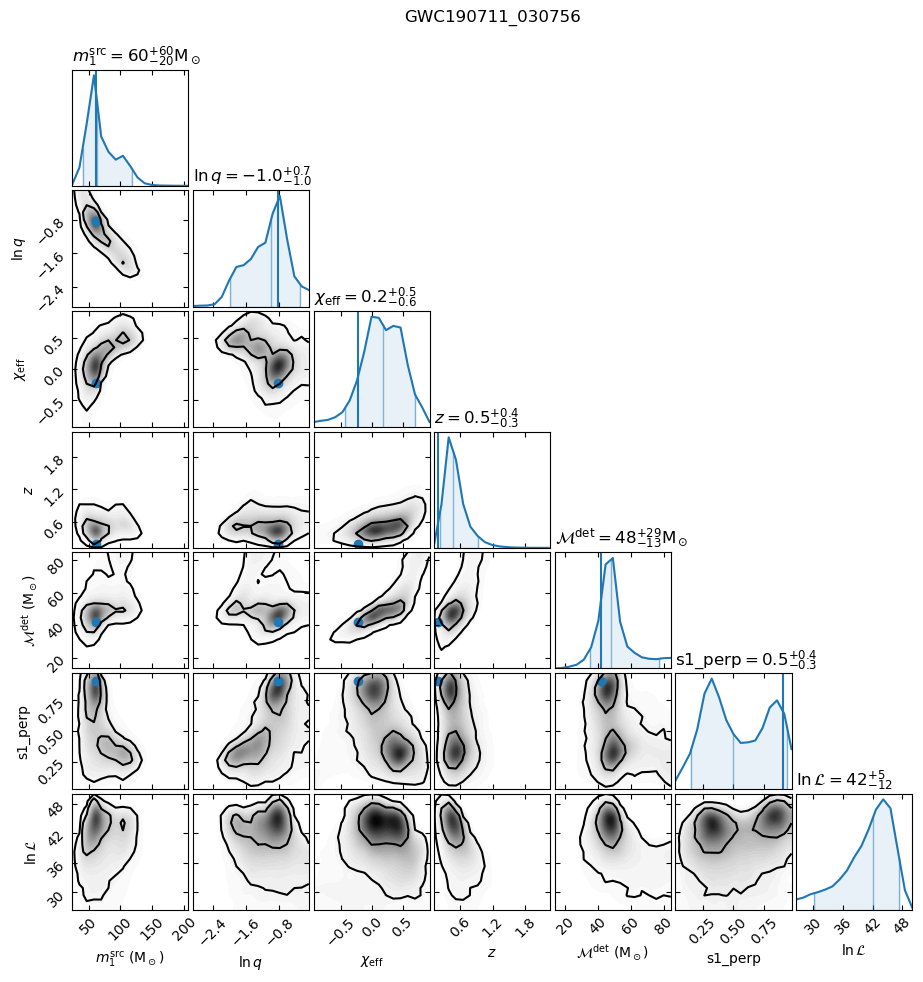

In [14]:
cp = gw_plotting.CornerPlot(s0[['m1_source', 'lnq', 'chieff', 'z','mchirp','s1_perp', 'lnl']])
cp.plot()
cp.scatter_points(max_lnl)
cp.fig.suptitle(eventname);

In [47]:
# We provide the .npz objects which can be used for running cogwheel PE for different priors
# at samples_dir/f'{eventname}/*.npz
# see https://github.com/jroulet/cogwheel/tree/main/tutorials for running cogwheel

## 2. PE samples of all events (including LVK, OGC and 22-only IAS events)

In [34]:
# All_Event_samples_IAS_spin_prior.pkl and All_Event_samples_LVC_spin_prior.pkl contain the PE samples for all events
# Please download the them from https://drive.google.com/drive/folders/1YkuIo-yIJhIOSX3B0zRGlSJzwIT5D61U?usp=sharing
# and rename the path below
with open('/data/jayw/IAS/GW/Data/HM_O3a_search/PE_samples/All_Event_samples_IAS_spin_prior.pkl', 'rb') as f:
    all_evn_samples = pickle.load(f)

In [35]:
lnl_diff_allow = 25
# This is the maximum allowed difference in log-likelihood between the maximum and the rest of the samples
# This is introduced to make the plot look cleaner, otherwise tails of the distributions can be very long

for evn_name in all_evn_samples:
    if evn_name not in ['GW200305_084739','GW200210_005122']:
        evn = all_evn_samples[evn_name]
        mask = evn['lnl'] > (evn['lnl'].max() - lnl_diff_allow)
        for key in evn:
            if evn[key] is not None:
                evn[key] = evn[key][mask]
        all_evn_samples[evn_name] = evn

In [36]:
import os, sys, scipy
import matplotlib as mpl

sys.path.insert(0, '/data/jayw/IAS/GW/Data/HM_O3a_search/PE_samples/')
import grid as gd
# grid.py is given in the github repo, add the path to it using sys.path.insert

tab20 = list(mpl.cm.get_cmap('tab20').colors)
tab20b = list(mpl.cm.get_cmap('tab20b').colors)
COLORS = tab20[ : : 2] + tab20[1 : : 2] + tab20b  # 40 colors

c = np.array(
    [[240,0,0],
     [239,133,0],
     [223,204,0],
     [153,194,0],
     [0,109,0]]) / 255

r, g, b = [scipy.interpolate.interp1d(np.linspace(0, 1, len(c)), y, kind='cubic')
           (np.linspace(0, 1, 255)) for y in c.T]

cm = mpl.colors.ListedColormap(np.vstack([r, g, b]).T)
cm.set_under(color=mpl.colors.to_hex(COLORS[7]), alpha=0.15)
cm.set_over(color=mpl.colors.to_hex(COLORS[0]), alpha=0.9)
import o3b_catalog_tables as tables
new_evnames_HM = tables.new_evnames_HM[::-1]

def expanded_rng(x, e=1.05):
    a = min(x)
    b = max(x)
    c = (a + b) / 2
    d = b - a
    return c - d/2*e, c + d/2*e

In [37]:
def make_multievent_plot(plot_2d_params=['mtot_source', 'chieff'], ranges_2d=None,
                         figsize=(8,4), evnames=None, xlim=None, ylim=None, fill=False, fractions=[1-np.exp(-.5)],
                         zoom=2, linewidths=1.6, sigma_gaussian_filter=0, pastro_colors=True,
                         set_legend=False, fig=None, ax=None,
                         colors=None, scatter_marker='o', scatter_marker_size=2, scatter_alpha=1):
    if evnames is None:
        evnames = list(all_evn_samples)
    if ranges_2d is None:
        ranges_2d = {ev: None for ev in evnames}
        
    grids = {ev: gd.Grid.from_samples(plot_2d_params, all_evn_samples[ev], pdf_key=ev, range=ranges_2d[ev],
                                      bins=80, weights=all_evn_samples[ev]['weights'])
             for ev in evnames}
    for g in grids.values():
        g.change_resolution(zoom)
        g.gaussian_filter(sigma_gaussian_filter)
    if pastro_colors:
        colors=[]
        for ev in evnames:
            if ev in new_evnames_HM:
                pastro = cands_dict[ev[:2]+'C'+ev[2:]]['pastro']
                colors.append(cm(pastro*2-1,alpha=0.7))
            else:
                colors.append(cm(-2001))

    mg = gd.MultiGrid([g for g in grids.values()],
                      colors=colors, fill=fill,
                      fractions=fractions, linestyles='-')   

    for ps in mg.plotstyles:
        ps.style_2d.linewidths = linewidths

    mg.plot_2d(*plot_2d_params, figsize=figsize, xlim=xlim, ylim=ylim, set_legend=set_legend,
               fig=fig, ax=ax)
    plt.grid(linestyle=':')
    
    if scatter_marker is not None:
        for evclr, ev in zip(colors, evnames):
            plt.scatter(np.median(all_evn_samples[ev][plot_2d_params[0]]), np.median(all_evn_samples[ev][plot_2d_params[1]]),
                        marker=scatter_marker, s=scatter_marker_size,
                        color=evclr, cmap=cm)# alpha=scatter_alpha,

/tmp/ipykernel_869154/1399137203.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.median(all_evn_samples[ev][plot_2d_params[0]]), np.median(all_evn_samples[ev][plot_2d_params[1]]),


Text(0.5, 1.0, 'Uniform in $\\chi_\\mathrm{eff}$ prior')

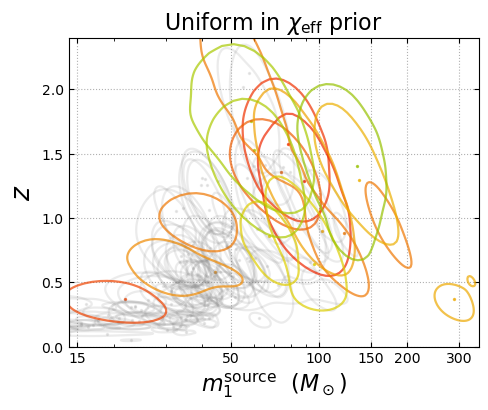

In [38]:
plot_2d_params = ['m1_source', 'z']
ranges_2d = {ev: [expanded_rng(samples['m1_source']), None]
             for ev, samples in all_evn_samples.items()}

make_multievent_plot(plot_2d_params, ranges_2d, figsize=(5,3), xlim=(14, 350), ylim=(0,2.4), 
                     evnames=all_evn_samples.keys(),
                     sigma_gaussian_filter=4, fractions=[.5])

plt.tight_layout()
atest = plt.gca()
atest.set_xscale('log')
atest.set_xticks([15, 50, 100, 150, 200, 300])
atest.set_xticklabels(['15', '50', '100', '150', '200', '300'])
atest.set_xlim(right=350)
atest.figure.set_figheight(4)
atest.set_xlabel(r'$m^\mathrm{source}_1\ \ (M_\odot)$', fontsize=16)
atest.set_ylabel('$z$', fontsize=19);
atest.set_title('Uniform in $\chi_\mathrm{eff}$ prior', fontsize=16)

/tmp/ipykernel_869154/1399137203.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.median(all_evn_samples[ev][plot_2d_params[0]]), np.median(all_evn_samples[ev][plot_2d_params[1]]),


Text(0.5, 1.0, 'Uniform in $\\chi_\\mathrm{eff}$ prior')

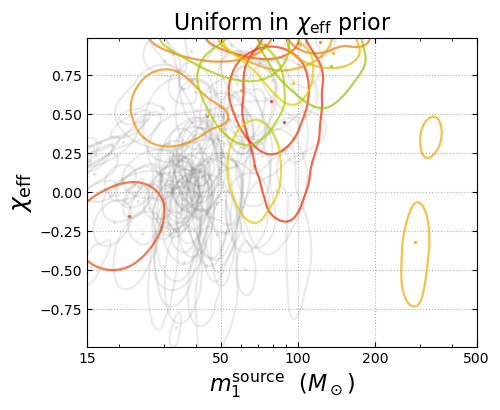

In [39]:
plot_2d_params = ['m1_source', 'chieff']
ranges_2d = {ev: [expanded_rng(samples['m1_source']), None]
             for ev, samples in all_evn_samples.items()}

make_multievent_plot(plot_2d_params, ranges_2d, figsize=(5,3), xlim=(15, 350), ylim=(-0.99,0.99), 
                     evnames=all_evn_samples,
                     sigma_gaussian_filter=4, fractions=[.5])
plt.tight_layout()
atest = plt.gca()
atest.set_xscale('log')
atest.set_xticks([15, 50, 100, 200, 500])
atest.set_xticklabels(['15', '50', '100', '200', '500'])
atest.set_yticks([-0.75, -0.50, -0.25, 0.00, 0.25, 0.50, 0.75])
atest.set_xlabel(r'$m^\mathrm{source}_1\ \ (M_\odot)$', fontsize=16)
atest.set_ylabel('$\\chi_{{\\rm eff}}$', fontsize=18)
atest.figure.set_figheight(4)
atest.set_xlim(right=500); 
atest.set_title('Uniform in $\chi_\mathrm{eff}$ prior', fontsize=16)
# plt.savefig('/data/jayw/CCA/Plots/trash.pdf', bbox_inches='tight')

/tmp/ipykernel_869154/1399137203.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.median(all_evn_samples[ev][plot_2d_params[0]]), np.median(all_evn_samples[ev][plot_2d_params[1]]),


Text(0.5, 1.0, 'Isotropic spin prior')

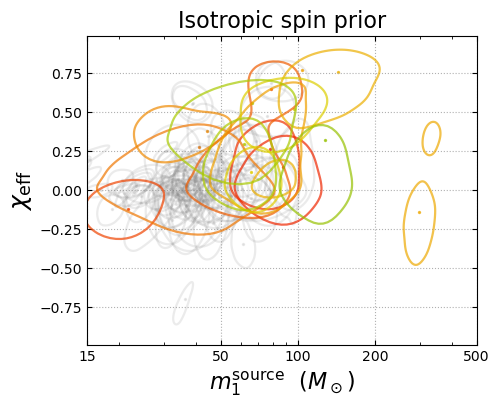

In [32]:
plot_2d_params = ['m1_source', 'chieff']
ranges_2d = {ev: [expanded_rng(samples['m1_source']), None]
             for ev, samples in all_evn_samples.items()}

make_multievent_plot(plot_2d_params, ranges_2d, figsize=(5,3), xlim=(15, 350), ylim=(-0.99,0.99), 
                     evnames=all_evn_samples,
                     sigma_gaussian_filter=4, fractions=[.5])
plt.tight_layout()
atest = plt.gca()
atest.set_xscale('log')
atest.set_xticks([15, 50, 100, 200, 500])
atest.set_xticklabels(['15', '50', '100', '200', '500'])
atest.set_yticks([-0.75, -0.50, -0.25, 0.00, 0.25, 0.50, 0.75])
atest.set_xlabel(r'$m^\mathrm{source}_1\ \ (M_\odot)$', fontsize=16)
atest.set_ylabel('$\\chi_{{\\rm eff}}$', fontsize=18)
atest.figure.set_figheight(4)
atest.set_xlim(right=500); 
atest.set_title('Isotropic spin prior', fontsize=16)
# plt.savefig('/data/jayw/CCA/Plots/trash.pdf', bbox_inches='tight')